In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm, probplot, rankdata
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from typing import Tuple, Dict, Optional, Set, List
from scipy.stats import mannwhitneyu

In [2]:
path = 'AB_Testing_Data.csv'

In [3]:
ab_test_df = pd.read_csv(path)

In [4]:
ab_test_df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


Null hypothesis (H₀): The means or distributions of income in the control and test groups do not differ. Alternative hypothesis (H₁): The means or distributions of income in the control and test groups differ.

In [5]:
ab_test_df = ab_test_df.rename(columns = lambda column_name: column_name.lower())

In [6]:
ab_test_df.shape

(10000, 3)

In [7]:
ab_test_df.dtypes

user_id           int64
variant_name     object
revenue         float64
dtype: object

In [8]:
ab_test_df.nunique()

user_id         6324
variant_name       2
revenue          101
dtype: int64

In [9]:
ab_test_df.isna().sum()

user_id         0
variant_name    0
revenue         0
dtype: int64

In [10]:
ab_test_df['variant_name'].value_counts(normalize=True)

variant_name
variant    0.5016
control    0.4984
Name: proportion, dtype: float64

In [11]:
ab_test_df.groupby('user_id')['variant_name'].nunique().value_counts(normalize=True)

variant_name
1    0.756325
2    0.243675
Name: proportion, dtype: float64

<Axes: >

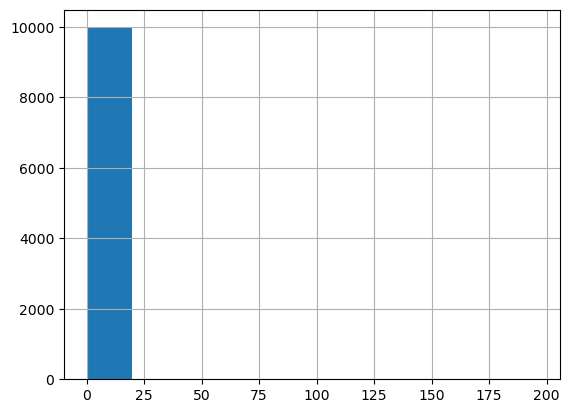

In [12]:
ab_test_df['revenue'].hist()

In [13]:
ab_test_df[ab_test_df.duplicated()]

,user_id,variant_name,revenue
106,7704,control,0.0
195,8406,variant,0.0
224,7042,variant,0.0
302,4409,control,0.0
422,1621,variant,0.0
...,...,...,...
9989,2444,variant,0.0
9993,2400,variant,0.0
9994,3129,control,0.0
9995,1981,control,0.0


In [14]:
ab_df_unique = ab_test_df.drop_duplicates()

In [15]:
ab_df_unique.head()

,user_id,variant_name,revenue
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [1]:
ab_df_unique['variant_name'].value_counts(normalize=True)
# Samples are almost identical, we can apply ab test

NameError: name 'ab_df_unique' is not defined

In [17]:
len(ab_df_unique)

7933

In [18]:
ab_df_unique.groupby('variant_name', as_index =False)\
            .agg({'revenue' : [np.mean, np.std, pd.Series.mode, 'count', np.sum]})

variant_name   revenue                             
                    mean       std mode count     sum
0      control  0.161842  3.367815  0.0  3973  643.00
1      variant  0.088755  1.479239  0.0  3960  351.47

In [19]:
ab_df_unique['revenue'].describe()

count    7933.000000
mean        0.125359
std         2.602527
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: revenue, dtype: float64

In [20]:
control =ab_df_unique.query("variant_name =='control'").reset_index(drop= True)

In [21]:
test =ab_df_unique.query("variant_name =='variant'").reset_index(drop= True)

(0.0, 10.0)

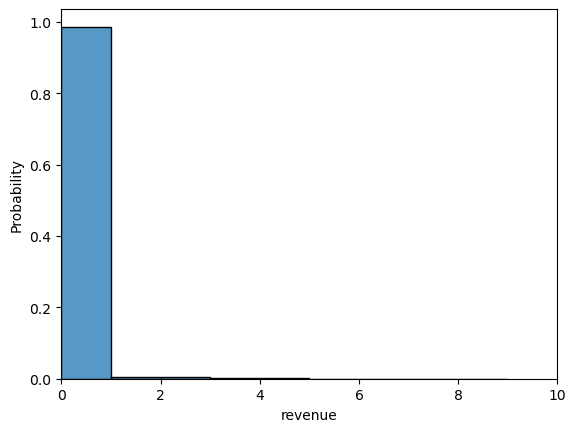

In [22]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(control['revenue'],
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

(0.0, 10.0)

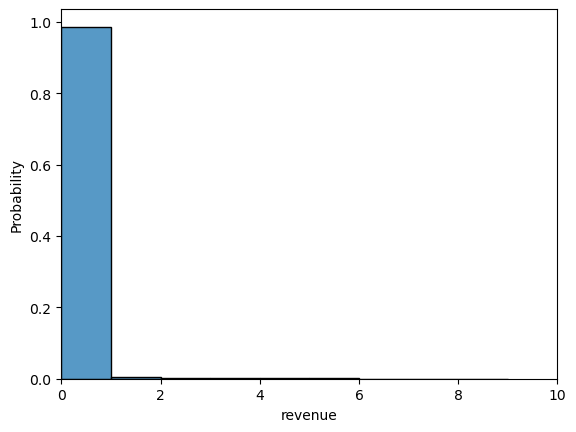

In [23]:
fig = plt.figure()
ax_clicks = fig.add_subplot()
clicks_distr = sns.histplot(test['revenue'], 
                            bins=range(0, 10),
                            kde=False,
                            ax=ax_clicks,
                            stat='probability')
ax_clicks.set_xlim((0, 10))

In [24]:
control_revenue = ab_df_unique[ab_df_unique['variant_name'] == 'control']['revenue']
test_revenue = ab_df_unique[ab_df_unique['variant_name'] == 'variant']['revenue']

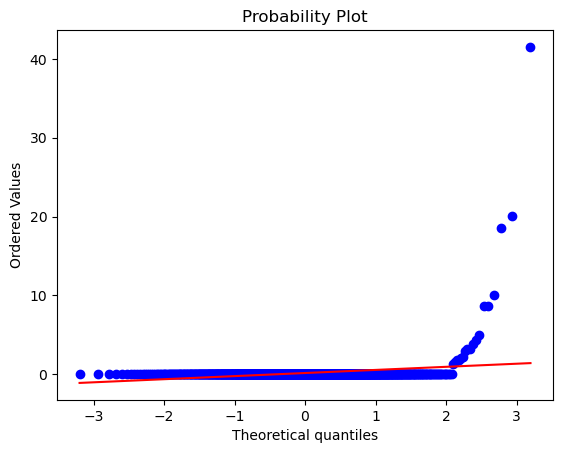

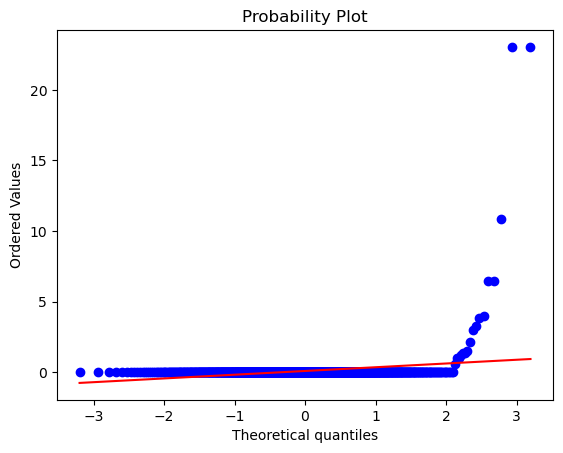

In [25]:
probplot(np.random.choice(control_revenue,1000), dist="norm",plot=plt)
plt.show()
probplot(np.random.choice(test_revenue,1000), dist="norm",plot=plt)
plt.show()

The data is not normally distributed, in order to check the p-value we need the Mann-Whitney test and the Bootstrap method.

There is a shoulder to the right, it is better to use Bootstrap (Bootstrap is an expensive procedure)

#  Mann–Whitney U test 

In [26]:
u_stat, p_value = mannwhitneyu(control_revenue, test_revenue)

In [27]:
u_stat, p_value

(7882388.0, 0.5128877468183902)

p_value=0.51, если округлить, то можно опровергнуть нулевую гипотезу и предполагаем, что различия статистически значимые.

# Bootstrap test

In [28]:
np.random.seed(42)
n = 10000
control_means = np.random.choice(control_revenue, size=(n, len(control_revenue)), replace=True).mean(axis=1)
test_means = np.random.choice(test_revenue, size=(n, len(test_revenue)), replace=True).mean(axis=1)

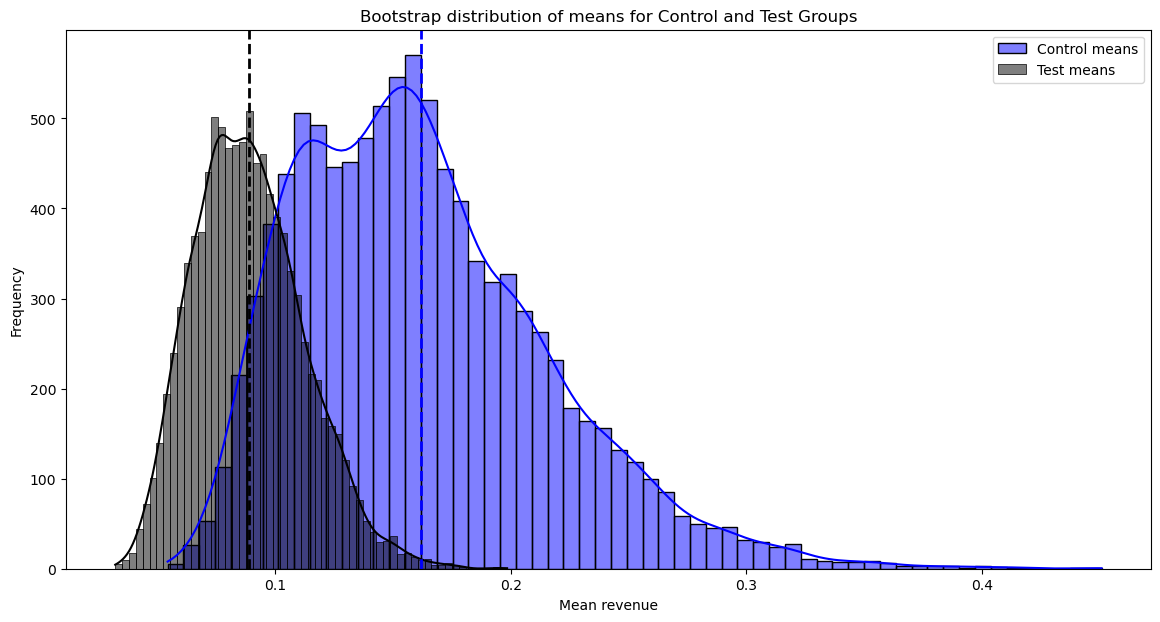

In [44]:
plt.figure(figsize=(14, 7))

sns.histplot(control_means, color='blue', kde=True, label='Control means')
sns.histplot(test_means, color='black', kde=True, label='Test means')

plt.axvline(control_revenue.mean(), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(test_revenue.mean(), color='black', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Bootstrap distribution of means for Control and Test Groups')
plt.xlabel('Mean revenue')
plt.ylabel('Frequency')
plt.show()

# Выводы

In [43]:
control_mean = np.mean(control_means).round(2)
variant_mean = np.mean(test_means).round(2)
mann_whitney_p_value = p_value.round(2)

control_mean, variant_mean, mann_whitney_p_value

(0.16, 0.09, 0.51)

Хоть тест Манна-Уитни  показвает p_value=0.51,т.е у нас есть основание опровергнуть H₀.

Но метод Bootstrap показал отствие явного различия: распределения сильно перекрываются, это может свидетельствовать о том, что разница между средними значениями групп незначительна, и эффект введенных изменений мал.

Возможная незначительная разница: это не обязательно означает, что различия нет, но, скорее всего, если разница существует, она незначительная или статистически незначимая.